In [1]:
# 13_efficiency_dashboards.ipynb
# 📊 Efficiency Dashboards

# Requirements: pandas, numpy, matplotlib, seaborn (install via `pip install pandas numpy matplotlib seaborn`)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from IPython.display import display

DATA_DIR = Path("./data")

plt.style.use("seaborn-v0_8")
plt.rcParams["figure.figsize"] = [14, 7]
sns.set_palette("crest")
pd.options.display.float_format = "{:.2f}".format

print("Data directory:", DATA_DIR.resolve())


Data directory: /home/bluescar/jupyter/cbb/starter_pack/artifacts/data


# 🔍 What You'll Build

> **Beginner tip:** Dashboards condense a lot of information. After each section, write down one takeaway so you do not feel overwhelmed by the charts.

Assemble dashboards to benchmark tempo-free efficiency and concede quick scouting hits. You'll:
- profile team-level offensive, defensive, and pace metrics for the target season
- segment conferences to surface how styles differ across the country
- chart net rating vs. a chosen metric to spotlight extreme programs
- review rolling net rating to capture momentum for highlighted teams


In [2]:
# 📅 Discover available seasons
season_files = sorted(p.stem for p in (DATA_DIR / 'team_season_stats').glob('*.csv'))
print(f"Team season files available ({len(season_files)}):")
print(', '.join(season_files[:10]))
if len(season_files) > 10:
    print('…')
    print(', '.join(season_files[-5:]))


Team season files available (21):
2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014
…
2021, 2022, 2023, 2024, 2025


## 🛠️ Set dashboard parameters
Keep the defaults until you see the workflow end to end. Then experiment with conference filters or different scatter plot axes.
Tune these controls to focus on specific conferences, teams, or metric combinations before running the rest of the notebook.


In [5]:
# 🔁 Parameters
TARGET_SEASON = 2025  # choose any season listed above
PACE_BUCKETS = [65, 70, 75]  # boundaries for classifying team tempo bands (possessions per 40)
FOCUS_CONFERENCES = []  # e.g. ['ACC', 'SEC'] to limit the dashboard
HIGHLIGHT_TEAMS = ['Dayton', 'Michigan']  # teams to feature in tables and charts
TOP_N_RATINGS = 15  # number of teams to show in the net rating table
ROLLING_WINDOW = 5  # games for rolling net rating trend

DASHBOARD_COLUMNS = {
    'pace': 'Pace',
    'teamStats_rating': 'OffRtg',
    'opponentStats_rating': 'DefRtg',
    'teamStats_fourFactors_effectiveFieldGoalPct': 'eFG%',
    'teamStats_fourFactors_turnoverRatio': 'TOV%',
    'teamStats_fourFactors_offensiveReboundPct': 'ORB%',
    'teamStats_fourFactors_freeThrowRate': 'FTR'
}

SCATTER_X = 'teamStats_rating'  # column name to plot on the x-axis (must exist in the dashboard data)
SCATTER_Y = 'net_rating'  # column name to plot on the y-axis (supports derived columns like net_rating)

print(f"Analyzing season: {TARGET_SEASON}")
if FOCUS_CONFERENCES:
    print("Conference filter:", ', '.join(FOCUS_CONFERENCES))
else:
    print("Conference filter: none")
print("Highlight teams:", ', '.join(HIGHLIGHT_TEAMS) if HIGHLIGHT_TEAMS else 'auto-select based on net rating')


Analyzing season: 2025
Conference filter: none
Highlight teams: Dayton, Michigan


## 📥 Load season and game data
This step brings in the two core tables used throughout the notebook. Skim the preview to ensure both have the columns you expect.
Pull team season summaries plus game logs so dashboards can cover both long-term efficiency and rolling trends.


In [6]:
# 🗂️ Read datasets
season_path = DATA_DIR / 'team_season_stats' / f'{TARGET_SEASON}.csv'
game_path = DATA_DIR / 'team_game_stats' / f'{TARGET_SEASON}.csv'

if not season_path.exists():
    raise FileNotFoundError(f"Missing team season file: {season_path}")
if not game_path.exists():
    raise FileNotFoundError(f"Missing team game file: {game_path}")

team_season = pd.read_csv(season_path)
team_games = pd.read_csv(game_path)
team_games['startDate'] = pd.to_datetime(team_games['startDate'])

print(f"Season teams: {team_season.shape[0]}")
print(f"Game logs: {team_games.shape[0]}")

display(team_season.head(3))
display(team_games.head(3))


Season teams: 364
Game logs: 12569


/tmp/ipykernel_30486/2552763057.py:11: DtypeWarning: Columns (93) have mixed types. Specify dtype option on import or set low_memory=False.
  team_games = pd.read_csv(game_path)


,season,seasonLabel,teamId,team,conference,games,wins,losses,totalMinutes,pace,...,opponentStats_fourFactors_freeThrowRate,opponentStats_fourFactors_offensiveReboundPct,opponentStats_fourFactors_turnoverRatio,opponentStats_fourFactors_effectiveFieldGoalPct,opponentStats_assists,opponentStats_blocks,opponentStats_steals,opponentStats_possessions,opponentStats_rating,opponentStats_trueShooting
0,2025,20242025,1,Abilene Christian,WAC,32,16,16,1310,66.40,...,49.30,29.10,0.25,50.00,383,143,259,2172,103.50,55.20
1,2025,20242025,2,Air Force,Mountain West,32,4,28,1310,61.10,...,35.40,26.80,0.16,54.60,410,103,217,1999,117.90,58.00
2,2025,20242025,3,Akron,MAC,35,28,7,1415,69.10,...,32.10,30.60,0.18,49.40,418,88,246,2445,107.40,53.30


,gameId,season,seasonLabel,seasonType,startDate,startTimeTbd,teamId,team,conference,opponentId,...,teamStats_points_byPeriod_2,opponentStats_points_byPeriod_2,teamStats_points_byPeriod_3,opponentStats_points_byPeriod_3,teamStats_points_byPeriod_4,opponentStats_points_byPeriod_4,teamStats_points_byPeriod,opponentStats_points_byPeriod,teamStats_points_byPeriod_5,opponentStats_points_byPeriod_5
0,24,2025,20242025,regular,2024-11-04 21:00:00+00:00,False,115,IU Indianapolis,Horizon,492,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,24,2025,20242025,regular,2024-11-04 21:00:00+00:00,False,492,IU Columbus,NaN,115,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,25,2025,20242025,regular,2024-11-04 22:00:00+00:00,False,171,Middle Tennessee,CUSA,493,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 🧮 Build team efficiency table
The table acts as the foundation for every later chart. Confirm the tempo band labels make sense and note which teams rank near the top.
Create a sortable table with wins, tempo band, tempo-free factors, and derived net rating to anchor the dashboards.


In [7]:
# 📊 Efficiency summary
target_columns = ['team', 'conference', 'games', 'wins', 'losses', 'pace', 'teamStats_rating', 'opponentStats_rating',
                  'teamStats_fourFactors_effectiveFieldGoalPct', 'teamStats_fourFactors_turnoverRatio',
                  'teamStats_fourFactors_offensiveReboundPct', 'teamStats_fourFactors_freeThrowRate']
missing = [col for col in target_columns if col not in team_season.columns]
if missing:
    raise KeyError(f"Missing expected columns in team season file: {missing}")

season_view = team_season[target_columns].copy()
season_view = season_view.assign(
    win_pct=lambda df: df['wins'] / df['games'],
    net_rating=lambda df: df['teamStats_rating'] - df['opponentStats_rating']
)

percent_cols = [
    'teamStats_fourFactors_effectiveFieldGoalPct',
    'teamStats_fourFactors_turnoverRatio',
    'teamStats_fourFactors_offensiveReboundPct',
    'teamStats_fourFactors_freeThrowRate'
]
for col in percent_cols:
    season_view[col] = season_view[col] * 100

if FOCUS_CONFERENCES:
    season_view = season_view[season_view['conference'].isin(FOCUS_CONFERENCES)]
    print(f"Teams after conference filter: {season_view.shape[0]}")

sorted_buckets = sorted(PACE_BUCKETS)
edges = [-np.inf] + sorted_buckets + [np.inf]
labels = []
for left, right in zip(edges[:-1], edges[1:]):
    if left == -np.inf:
        labels.append(f"<{right}")
    elif right == np.inf:
        labels.append(f"≥{int(left)}")
    else:
        labels.append(f"{int(left)}-{int(right)}")
season_view['tempo_band'] = pd.cut(season_view['pace'], bins=edges, labels=labels, right=False)

if season_view.empty:
    print("No teams match the current filters. Adjust parameters above and re-run.")
else:
    display_cols = [
        ("Team", 'team'),
        ("Conf", 'conference'),
        ("G", 'games'),
        ("W", 'wins'),
        ("L", 'losses'),
        ("Win%", 'win_pct'),
        ("Tempo band", 'tempo_band')
    ]
    for src, label in DASHBOARD_COLUMNS.items():
        if src not in season_view.columns:
            raise KeyError(f"Column {src} defined in DASHBOARD_COLUMNS is missing from the data frame")
        display_cols.append((label, src))
    display_cols.append(("NetRtg", 'net_rating'))

    dashboard = season_view[[col for _, col in display_cols]].copy()
    dashboard.columns = [name for name, _ in display_cols]
    dashboard = dashboard.sort_values("NetRtg", ascending=False)

    top_table = dashboard.head(TOP_N_RATINGS).round(2)
    print(f"Top {len(top_table)} teams by net rating")
    display(top_table)

    if HIGHLIGHT_TEAMS:
        highlight_table = dashboard[dashboard['Team'].isin(HIGHLIGHT_TEAMS)].round(2)
        if highlight_table.empty:
            print("No highlight teams found in filtered data.")
        else:
            print("Highlight teams snapshot:")
            display(highlight_table)


Top 15 teams by net rating


,Team,Conf,G,W,L,Win%,Tempo band,Pace,OffRtg,DefRtg,eFG%,TOV%,ORB%,FTR,NetRtg
71,Duke,ACC,39,35,4,0.90,65-70,65.70,126.70,95.40,5790.00,14.00,2790.00,3290.00,31.30
309,UC San Diego,Big West,35,30,5,0.86,<65,63.10,125.90,97.90,5550.00,14.00,2680.00,3220.00,28.00
101,Gonzaga,WCC,35,26,9,0.74,65-70,67.30,124.50,100.60,5600.00,14.00,2880.00,3070.00,23.90
112,Houston,Big 12,40,35,5,0.88,<65,60.50,116.90,93.30,5170.00,14.00,3470.00,2720.00,23.60
86,Florida,SEC,40,36,4,0.90,65-70,68.10,124.70,102.20,5490.00,16.00,3280.00,3490.00,22.50
332,VCU,A-10,35,28,7,0.80,<65,63.80,119.40,97.30,5260.00,17.00,3470.00,3210.00,22.10
159,Maryland,Big Ten,36,27,9,0.75,65-70,67.10,119.70,98.80,5360.00,15.00,2910.00,3310.00,20.90
69,Drake,MVC,35,31,4,0.89,<65,50.70,130.90,110.10,5480.00,21.00,3290.00,4230.00,20.80
161,McNeese,Southland,35,28,7,0.80,<65,59.70,128.50,107.80,5420.00,18.00,3250.00,3490.00,20.70
15,Auburn,SEC,38,32,6,0.84,65-70,67.50,121.60,101.80,5490.00,14.00,3160.00,3390.00,19.80


Highlight teams snapshot:


,Team,Conf,G,W,L,Win%,Tempo band,Pace,OffRtg,DefRtg,eFG%,TOV%,ORB%,FTR,NetRtg
169,Michigan,Big Ten,37,27,10,0.73,65-70,67.30,113.40,104.10,5380.00,20.00,2880.00,3570.00,9.30
63,Dayton,A-10,34,23,11,0.68,<65,61.90,117.80,110.20,5320.00,16.00,2850.00,3760.00,7.60


## 🧱 Conference efficiency snapshot
Aggregated conference stats help you compare league styles. Look for differences between pace and net rating to understand competitive balance.
Aggregate net rating and four-factor averages by conference to compare stylistic trends across leagues.


In [8]:
# 🧱 Conference summary
if season_view.empty:
    print("Conference view skipped because no teams passed the filters.")
else:
    agg_cols = {
        'net_rating': 'mean',
        'pace': 'mean',
        'teamStats_rating': 'mean',
        'opponentStats_rating': 'mean',
        'teamStats_fourFactors_effectiveFieldGoalPct': 'mean',
        'teamStats_fourFactors_turnoverRatio': 'mean',
        'teamStats_fourFactors_offensiveReboundPct': 'mean',
        'teamStats_fourFactors_freeThrowRate': 'mean',
        'win_pct': 'mean'
    }
    conference_summary = (
        season_view.groupby('conference')
        .agg(agg_cols)
        .reset_index()
        .sort_values('net_rating', ascending=False)
    )
    conference_summary = conference_summary.rename(columns={
        'conference': 'Conference',
        'net_rating': 'NetRtg',
        'pace': 'Pace',
        'teamStats_rating': 'OffRtg',
        'opponentStats_rating': 'DefRtg',
        'teamStats_fourFactors_effectiveFieldGoalPct': 'eFG%',
        'teamStats_fourFactors_turnoverRatio': 'TOV%',
        'teamStats_fourFactors_offensiveReboundPct': 'ORB%',
        'teamStats_fourFactors_freeThrowRate': 'FTR',
        'win_pct': 'Win%'
    })
    display(conference_summary.round(2).head(12))


,Conference,NetRtg,Pace,OffRtg,DefRtg,eFG%,TOV%,ORB%,FTR,Win%
23,SEC,9.91,66.67,116.81,106.90,5277.50,16.56,3059.38,3722.50,0.65
9,Big Ten,7.42,66.16,113.84,106.42,5270.56,16.44,2922.22,3402.78,0.60
5,Big 12,6.77,65.61,111.49,104.72,5162.50,17.06,3085.00,3191.88,0.58
6,Big East,5.07,64.67,111.50,106.43,5221.82,17.09,2924.55,3044.55,0.55
12,CUSA,4.95,65.38,110.30,105.35,5104.00,17.50,2842.00,3368.00,0.56
0,A-10,4.29,65.14,109.39,105.10,5112.67,17.40,2905.33,3379.33,0.56
18,MVC,3.98,63.22,113.55,109.57,5320.00,17.92,2753.33,3395.00,0.54
1,ACC,3.68,64.84,111.92,108.24,5165.56,16.89,2968.89,3266.11,0.54
25,SoCon,3.60,64.89,112.17,108.57,5177.00,17.60,3038.00,3114.00,0.52
30,WCC,3.45,65.97,112.30,108.85,5213.64,17.36,2913.64,3169.09,0.53


## 📈 Efficiency scatter plot
The scatter plot links two metrics at once. Use the median lines to see which teams sit above or below average on each axis.
Compare net rating against a selected metric and highlight tempo bands plus the teams you care about.


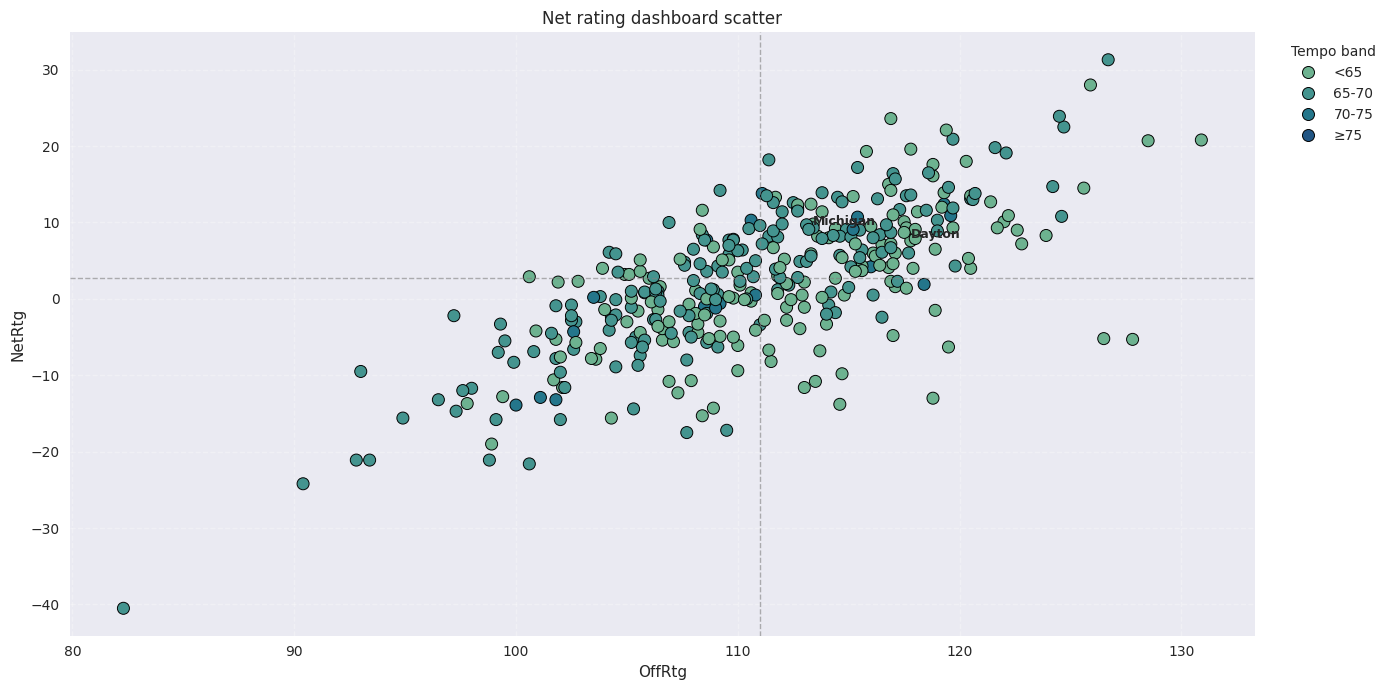

In [9]:
# 📈 Scatter dashboard
if season_view.empty:
    print("Scatter plot skipped because no teams passed the filters.")
else:
    metric_alias = {
        **{col: label for col, label in DASHBOARD_COLUMNS.items()},
        'net_rating': 'NetRtg',
        'pace': 'Pace',
        'win_pct': 'Win%'
    }
    if SCATTER_X not in season_view.columns:
        raise KeyError(f"SCATTER_X column '{SCATTER_X}' is not present in the data frame")
    if SCATTER_Y not in season_view.columns:
        raise KeyError(f"SCATTER_Y column '{SCATTER_Y}' is not present in the data frame")

    fig, ax = plt.subplots(figsize=(14, 7))
    sns.scatterplot(
        data=season_view,
        x=SCATTER_X,
        y=SCATTER_Y,
        hue='tempo_band',
        palette='crest',
        ax=ax,
        s=75,
        edgecolor='black'
    )
    ax.axvline(season_view[SCATTER_X].median(), color='gray', linestyle='--', linewidth=1, alpha=0.6)
    ax.axhline(season_view[SCATTER_Y].median(), color='gray', linestyle='--', linewidth=1, alpha=0.6)
    ax.set_xlabel(metric_alias.get(SCATTER_X, SCATTER_X))
    ax.set_ylabel(metric_alias.get(SCATTER_Y, SCATTER_Y))
    ax.set_title('Net rating dashboard scatter')

    if HIGHLIGHT_TEAMS:
        highlights = season_view[season_view['team'].isin(HIGHLIGHT_TEAMS)]
        for _, row in highlights.iterrows():
            ax.text(row[SCATTER_X], row[SCATTER_Y], row['team'], fontsize=9, weight='bold', ha='left', va='bottom')

    ax.grid(True, linestyle='--', alpha=0.3)
    ax.legend(title='Tempo band', bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.tight_layout()


## 🔄 Rolling net rating trends
Rolling averages show whether teams are getting better or worse over time. Focus on the slope of each line rather than individual game swings.
Track momentum by plotting rolling net rating across the season for the highlighted programs.


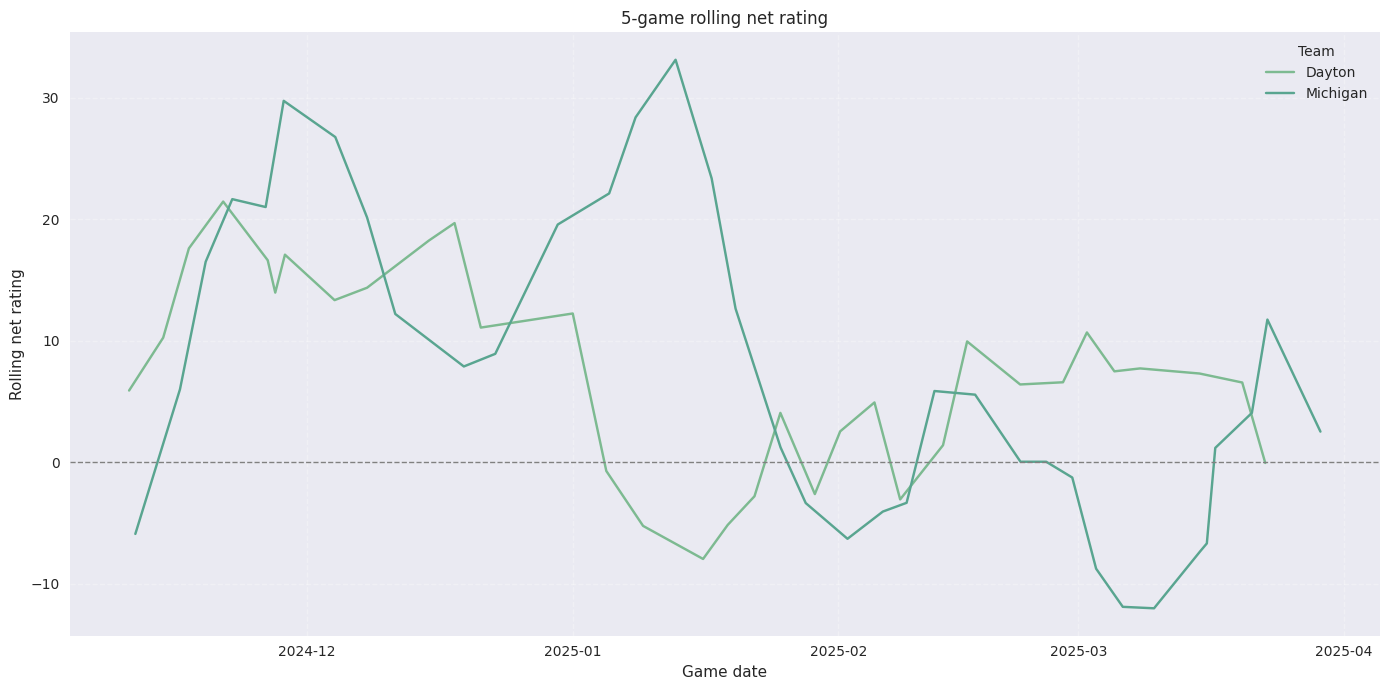

In [10]:
# 🔄 Rolling efficiency view
if season_view.empty:
    print("Rolling view skipped because no teams passed the filters.")
else:
    focus_teams = HIGHLIGHT_TEAMS
    if not focus_teams:
        focus_teams = (
            season_view.sort_values('net_rating', ascending=False)
            .head(3)['team']
            .tolist()
        )
        print("Auto-selected highlight teams:", ', '.join(focus_teams))

    focus_logs = team_games[team_games['team'].isin(focus_teams)].copy()
    if focus_logs.empty:
        print("No game logs found for the selected teams.")
    else:
        focus_logs = focus_logs.sort_values(['team', 'startDate'])
        focus_logs['net_rating'] = focus_logs['teamStats_rating'] - focus_logs['opponentStats_rating']
        focus_logs['rolling_net'] = focus_logs.groupby('team')['net_rating'].transform(
            lambda s: s.rolling(ROLLING_WINDOW, min_periods=1).mean()
        )

        fig, ax = plt.subplots(figsize=(14, 7))
        for team, subset in focus_logs.groupby('team'):
            ax.plot(subset['startDate'], subset['rolling_net'], label=team)
        ax.axhline(0, color='gray', linestyle='--', linewidth=1)
        ax.set_title(f'{ROLLING_WINDOW}-game rolling net rating')
        ax.set_xlabel('Game date')
        ax.set_ylabel('Rolling net rating')
        ax.legend(title='Team', bbox_to_anchor=(1, 1))
        ax.grid(True, linestyle='--', alpha=0.3)
        plt.tight_layout()


## 🗒️ Dashboard takeaways
Fill in this section with plain-language insights. Writing a short summary helps you communicate findings to coaches and teammates.
> - Replace these bullets with your efficiency observations.
> - Note tempo band quirks, conference gaps, or rising teams from the rolling chart.
> - Capture action items (e.g., revisit shot profile notebooks for a high-net team).


## ✅ Next steps
Export the tables or screenshots you want to share. Dashboards become more powerful when you integrate them with scouting notes.
- Blend in player dashboards from `11_player_comparison_dashboard.ipynb` for high-leverage matchups.
- Export the filtered `dashboard` DataFrame to CSV for sharing with coaches or analysts.
- Re-run the notebook after updating `requirements.txt` or adding new seasons to validate the visuals.
